# Objectif du projet


Analyser les Discours du Trône (1911–2012)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import matplotlib.dates as mdates

import spacy
from collections import Counter
from wordcloud import WordCloud


# modelisation 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# modèle linguistique anglais
nlp = spacy.load("en_core_web_sm") 
nlp.max_length = 2_000_000 



## test analyse de sentiment

#import nltk
#nltk.download('vader_lexicon')
#nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

/Users/g.palacio/IAE/nlp_speech_throne/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## I.  Chargement et exploration des données

In [2]:
data_path = Path.cwd().parent / "data"  # chemin pour récuperer les données


df = pd.read_excel( data_path /  "Speech_Throne_1911_2012_PM.xlsx")
df.head()


,Speech_Year,Date,PM,Parti,Text
0,1,1911-02-06,Herbert Henry Asquith,Libéral,"My Lords and Gentlemen, In opening the first P..."
1,2,1912-02-14,Herbert Henry Asquith,Libéral,"My Lords and Gentlemen, My relations with fore..."
2,3,1913-03-10,Herbert Henry Asquith,Libéral,"My Lords and Gentlemen, To-day being the fifti..."
3,4,1914-11-11,Herbert Henry Asquith,Libéral,"My Lords and Gentlemen, The energies and sympa..."
4,5,1916-02-15,Herbert Henry Asquith,Libéral,"My Lords and Gentlemen, It has been My duty to..."


In [3]:
df.duplicated(subset='Text').sum() # on vérifie s'il y a des doublons dans les discours 


np.int64(0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Speech_Year  105 non-null    int64         
 1   Date         105 non-null    datetime64[ns]
 2   PM           105 non-null    object        
 3   Parti        105 non-null    object        
 4   Text         105 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 4.2+ KB


df['Text'] contient 105 discours (un par ligne)

In [5]:
df.iloc[0]['Text'] #premier discour 

'My Lords and Gentlemen, In opening the first Parliament elected in My reign, the grievous loss which the Empire has sustained by the death of My beloved Father is upper most in My thoughts. When, a year ago, He addressed you from the Throne no one could have foreseen that His life of unceasing and devoted activity in the service of His subjects was so soon to be cut short. Bowing to the inscrutable decree of Providence, I take courage from His example, and I am sustained in My abiding sorrow by the sympathy extended to me by My people in every part of My Dominions. I have welcomed back My Uncle, the Duke of Connaught, on the completion of the Mission in South Africa, which I entrusted to him, and it has deeply gratified Me to learn that he was received with demonstrations of the utmost enthusiasm and loyalty in every part of My South African Dominions, and by every class of the community. I have welcomed back My Uncle, the Duke of Connaught, on the completion of the Mission in South A

**Vérification des valeurs manquantes**

In [6]:
df.isnull().sum() # Pas de valeurs manquantes

Speech_Year    0
Date           0
PM             0
Parti          0
Text           0
dtype: int64

**Statistiques**

In [7]:
# longueur des discours
df['n_tokens'] = df['Text'].str.split().apply(len) # nombre de tokens 
df['n_chars'] = df['Text'].str.len()  # nombre total de caractères (lettres, espaces, ponctuation) dans chaque discours

print(df[['n_tokens', 'n_chars']].describe())


          n_tokens       n_chars
count   105.000000    105.000000
mean   1577.885714   9863.514286
std     591.495161   3760.282135
min      74.000000    402.000000
25%    1307.000000   8289.000000
50%    1610.000000   9939.000000
75%    1914.000000  11922.000000
max    3074.000000  19383.000000


D'apres les statistiques sur les discours, on peut voir que : 

Le nombre moyen de mots par discours : ~1578 tokens

Maximum : 3 074 tokens 
et le minimum : 74 tokens (cas exceptionnel, probablement un discours très court)

In [8]:
# les discours les plus courts
print("\nDiscours les plus courts :")
print(df.sort_values('n_tokens').head(3)[['Speech_Year', 'n_tokens', 'Text']])



Discours les plus courts :
    Speech_Year  n_tokens                                               Text
39           40        74  My Lords and Members of the House of Commons: ...
10           11       152  My Lords and Members of the House of Commons, ...
30           31       256  My Lords and Members of the House of Commons, ...


In [9]:
#  les discours les plus longs
print("\nDiscours les plus longs :")
print(df.sort_values('n_tokens', ascending=False).head(3)[['Speech_Year', 'n_tokens', 'Text']])



Discours les plus longs :
    Speech_Year  n_tokens                                               Text
71           72      3074  My Lords and Members of the House of Commons, ...
15           16      2897  My Lords and Members of the House of Commons, ...
7             8      2885  My Lords and Gentlemen, The dissolution of the...


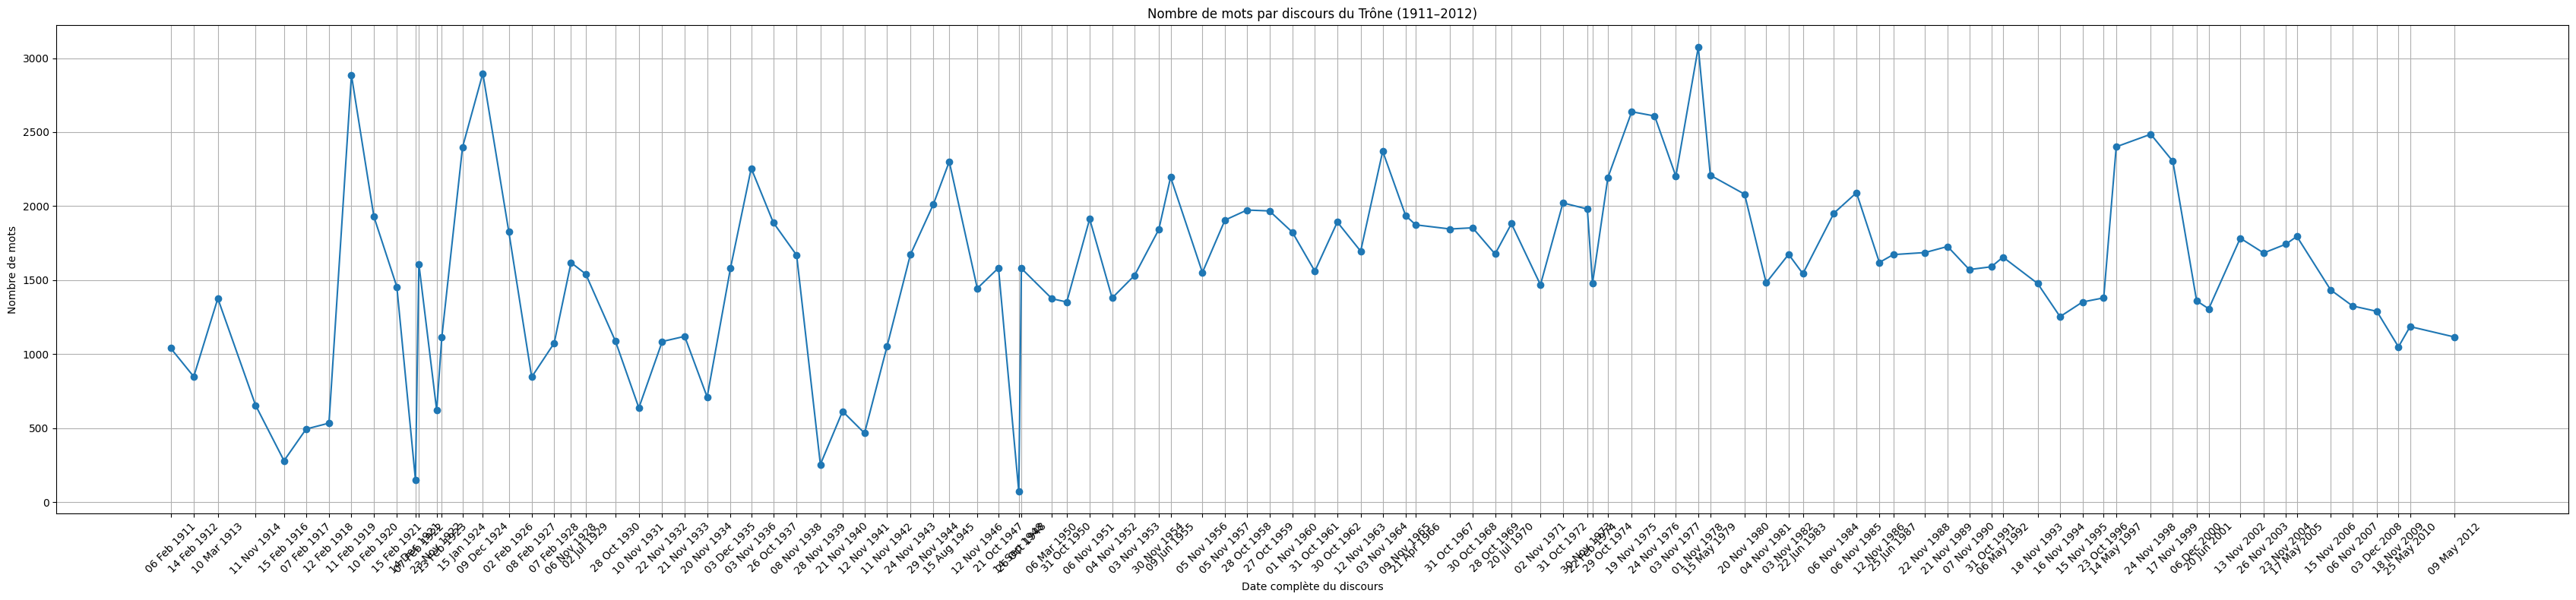

In [10]:
plt.figure(figsize=(34, 8))
plt.plot(df['Date'], df['n_tokens'], marker='o')  # 

plt.title("Nombre de mots par discours du Trône (1911–2012)")
plt.xlabel("Date complète du discours")
plt.ylabel("Nombre de mots")
plt.grid(True)

# Formatage de la date complète
date_format = mdates.DateFormatter('%d %b %Y')
plt.gca().xaxis.set_major_formatter(date_format)

# Ticks sur chaque discours
plt.xticks(df['Date'], rotation=45)

plt.tight_layout()
plt.show()

In [11]:
doc_complet = nlp(" ".join(df["Text"]).lower())  #  représente tout le corpus concaténé (donc 1 très long texte)
unique_words = set([token.text for token in doc_complet if token.is_alpha])
print(f"Mots différents dans tout le corpus : {len(unique_words)}")

Mots différents dans tout le corpus : 5210


## II. Nettoyage et prétraitement

**Les phrases les plus fréquentes dans l’ensemble des discours du Trône (1911–2012)**

In [12]:

#  toutes les phrases de tous les discours
all_sentences = []
for text in df['Text']:
    doc = nlp(" ".join(text.split()))
    all_sentences += [
        sent.text.strip()
        for sent in doc.sents
        if len(sent.text.strip()) > 20
    ]

# fréquence des phrases
sentence_freq = Counter(all_sentences)

#  10 plus fréquentes
print(" Phrases les plus fréquentes :\n")
for sent, count in sentence_freq.most_common(10):
    print(f"{count} × \"{sent}\"")

# liste des phrases à exclure si elles apparaissent dans au moins 5 discours
# pour éviter de garder des phrases trop fréquentes

seuil = 5
sentences_to_exclude = {
    sent for sent, count in sentence_freq.items() if count >= seuil
}

print(f"\n {len(sentences_to_exclude)} phrases seront exclues (≥ {seuil} occurrences)")


 Phrases les plus fréquentes :

49 × "Other measures will be laid before you."
36 × "My Lords and Members of the House of Commons, I pray that the blessing of Almighty God may rest upon your counsels."
19 × "Members of the House of Commons, Estimates for the public service will be laid before you."
12 × "Members of the House of Commons, Estimates for the Public Service will be laid before you."
10 × "Other measures will be laid before you in due course."
9 × "My Lords and Members of the House of Commons, My relations with foreign Powers continue to be friendly."
8 × "Members of the House of Commons, Estimates for the public services will be laid before you."
7 × "Schemes are being prepared for the improvement of the means of transport, for the stimulation of the depressed export trades, for the economic development of My Overseas Dependencies, for the improvement of the condition of agriculture, for the encouragement of the fishing industry, and for the improvement of the facilities fo

On observe que certains phrase sont répetés 49, 33 , etc .. fois, car il s'agit  des formules protocolaires, rituelles ou administratives


In [13]:
def preprocess(text):
    # Nettoyer les phrases du discours
    doc = nlp(" ".join(text.split()))
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip() not in sentences_to_exclude]

    # Reconstituer le texte nettoyé sans les phrases fréquentes
    filtered_text = " ".join(sentences).lower()

    #  pipeline de nettoyage
    doc_clean = nlp(filtered_text)
    tokens = [
        token.lemma_ for token in doc_clean
        if token.is_alpha and not token.is_stop and len(token) > 2
    ]
    return " ".join(tokens)


df['clean_text'] = df['Text'].apply(preprocess)


Cette fonction effectue une "pipeline" en appliquant  les étapes  suivantes :

- Convertit le texte en minuscules

- Tokenise le texte (découpe en mots)

- Retire la ponctuation, les chiffres et les stop words (mots peu informatifs)

- Lemmatisation : réduit les mots à leur forme de base (ex. "running" en "run")

- Garde uniquement les mots alphabétiques de plus de 2 lettres

 Le résultat est une version "propre" du discours

## III. Analyse exploratoire (EDA)

**Analyse stop words les plus fréquents**

In [14]:
# pour savoir quels stop words étaient présents initialement

doc_complet_raw = nlp(" ".join(df["Text"]))
stop_words_in_text = [token.text.lower() for token in doc_complet_raw if token.is_stop and token.is_alpha]


# Compter les fréquences
freq_stop = Counter(stop_words_in_text)

# Afficher les plus fréquents
print("Top 20 des stop words les plus fréquents :")
for word, count in freq_stop.most_common(20):
    print(f"{word:<10} {count}")


Top 20 des stop words les plus fréquents :
the        13491
of         9064
to         8800
and        8003
will       5354
in         4096
my         3111
for        2850
be         2752
a          2502
with       1499
on         1103
they       1055
their      831
that       806
by         804
you        778
which      771
i          562
before     543


In [15]:
# Nombre total de tokens dans le texte
total_tokens = len([token for token in doc_complet_raw if token.is_alpha])

# Nombre de stop words supprimés
n_stop_removed = len([token for token in doc_complet_raw if token.is_alpha and token.is_stop])

print(f"Nombre total de mots : {total_tokens}")
print(f"Nombre de stop words supprimés : {n_stop_removed}")
print(f"Proportion supprimée : {n_stop_removed / total_tokens:.2%}")

Nombre total de mots : 166094
Nombre de stop words supprimés : 83816
Proportion supprimée : 50.46%


Le nombre de stop words supprimés est de 83,819 : cela signifie que plus de la moitié des mots du corpus sont considérés comme des stop words

**comparaison texte avant/après prétraitement**

In [16]:
original = df['Text'][0]
cleaned = preprocess(df['Text'][0])

print("Texte original :\n", original[:500])  # on limite à 500 caractères
print("\nTexte nettoyé :\n", cleaned[:500])


Texte original :
 My Lords and Gentlemen, In opening the first Parliament elected in My reign, the grievous loss which the Empire has sustained by the death of My beloved Father is upper most in My thoughts. When, a year ago, He addressed you from the Throne no one could have foreseen that His life of unceasing and devoted activity in the service of His subjects was so soon to be cut short. Bowing to the inscrutable decree of Providence, I take courage from His example, and I am sustained in My abiding sorrow by 

Texte nettoyé :
 lord gentleman open parliament elect reign grievous loss empire sustain death beloved father upper thought year ago address throne foresee life unceasing devoted activity service subject soon cut short bow inscrutable decree providence courage example sustain abide sorrow sympathy extend people dominion welcome uncle duke connaught completion mission south africa entrust deeply gratify learn receive demonstration utmost enthusiasm loyalty south african domini

**Analyse de fréquence des mots (hors stop words)**

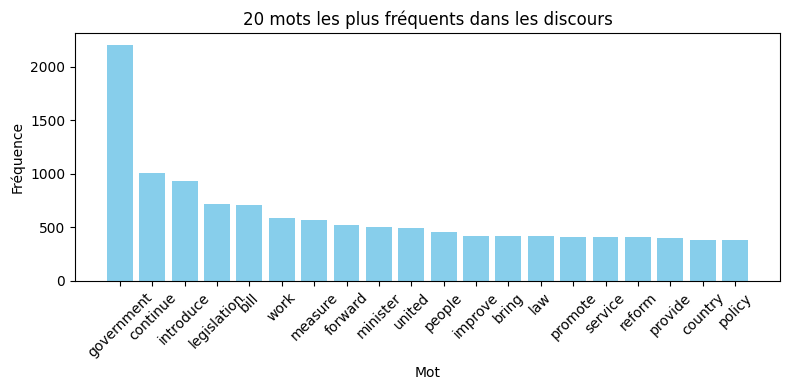

In [17]:
# Fusionner tous les discours nettoyés
corpus_clean = " ".join(df["clean_text"])

# Compter la fréquence des mots
word_freq = Counter(corpus_clean.split())

# Garder les 20 mots les plus fréquents
most_common = word_freq.most_common(20)

# Séparer les mots et leurs fréquences
words, freqs = zip(*most_common)

# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.bar(words, freqs, color='skyblue')
plt.title("20 mots les plus fréquents dans les discours")
plt.xlabel("Mot")
plt.ylabel("Fréquence")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Nuage de mots par période et monarque donnée**



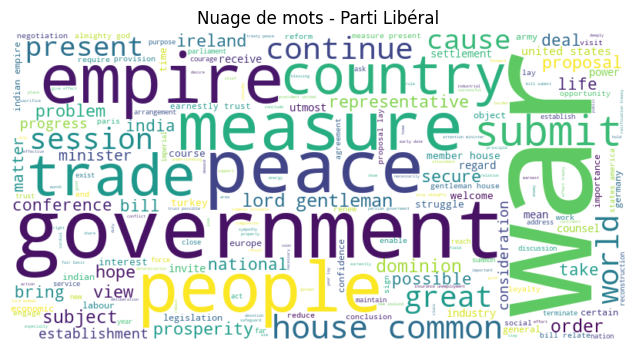

In [18]:
# Filtre les discours du parti Libéral
df_lib = df[df['Parti'] == "Libéral"]

#  textes nettoyés
text_g6 = " ".join(df_lib["clean_text"])

#  nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_g6)

# graphique
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots - Parti Libéral")
plt.show()

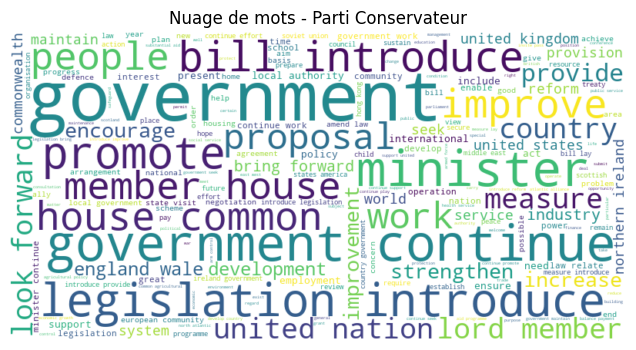

In [19]:
# Filtre les discours du parti Conservateur
df_cons = df[df['Parti'] == "Conservateur"]

#  textes nettoyés
text_g6 = " ".join(df_cons["clean_text"])

#  nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_g6)

# graphique
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots - Parti Conservateur")
plt.show()

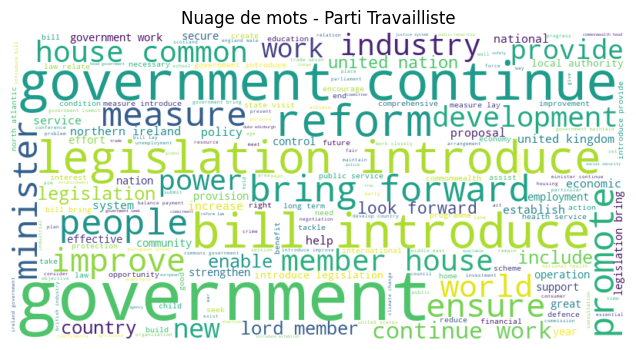

In [20]:
# Filtre les discours du parti Travailliste
df_trav = df[df['Parti'] == "Travailliste"]

#  textes nettoyés
text_g6 = " ".join(df_trav["clean_text"])

#  nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_g6)

# graphique
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots - Parti Travailliste")
plt.show()

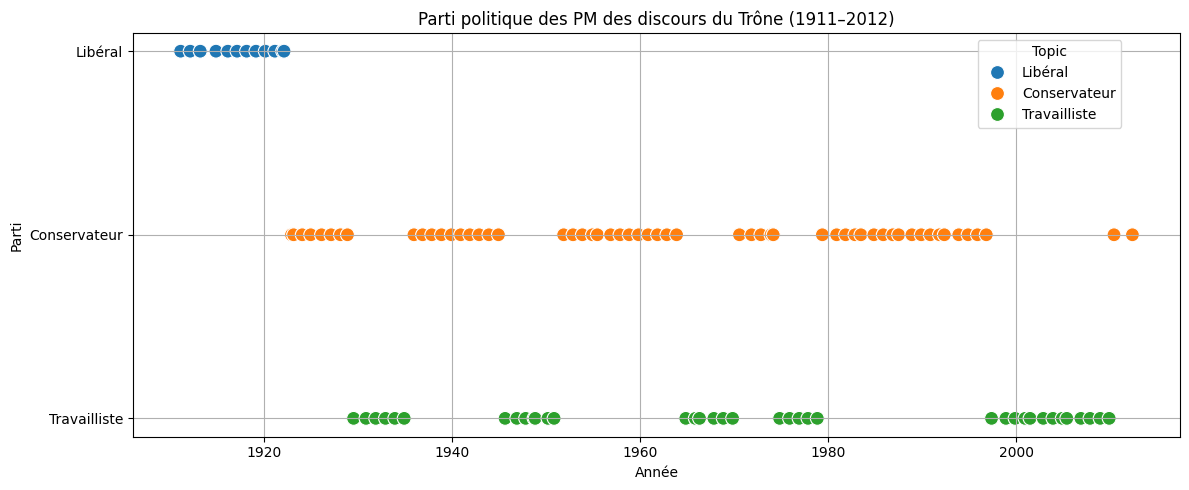

In [21]:
# graphique 
plt.figure(figsize=(12, 5))
sns.scatterplot(
    x='Date',
    y='Parti',
    hue='Parti',
    palette='tab10',
    data=df,
    s=100
)
plt.title("Parti politique des PM des discours du Trône (1911–2012)")
plt.xlabel("Année")
plt.ylabel("Parti")
plt.legend(title='Topic', bbox_to_anchor=(0.8, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## IV. Modélisation thématique avec LDA

### 1)  Vectorisation

On utilise CountVectirizer, en supprimant les mots trop fréquents (max_df=0.9), donc présents dans plus de 90% des discours, mais aussi on ignore les mots trop rares (min_df=10) → présents dans moins de 10 discours.

Ensuite on transforme la colonne clean_text en une matrice document-terme (DTM), où :

- chaque ligne = un discours

- chaque colonne = un mot

- chaque valeur = nombre de fois que le mot apparaît dans ce discours

In [22]:
cv = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = cv.fit_transform(df['clean_text'])

### 2) Entraînement du modèle LDA (Latent Dirichlet Allocation) 

In [23]:
lda = LatentDirichletAllocation(n_components=3, random_state=42) # pour 5 topics, choisi de manière arbitraire 
lda.fit(dtm)

LatentDirichletAllocation(n_components=3, random_state=42)

### 3) Exploration du vocabulaire

In [24]:
len(cv.get_feature_names_out()) # nombre total de mots uniques conservés après vectorisation

784

In [25]:
for i in range(10):
    random_word_id = random.randint(0, 784)
    print(cv.get_feature_names_out()[random_word_id])   # au hasard 10 mots 

weapon
britain
operate
propose
coal
order
ask
london
india
modernise


**Analyse d’un topic**

In [26]:
lda.components_   # matrice des poids : une ligne par topic, une colonne par mot

array([[  0.35917337,   0.34670089,   9.50054964, ...,   0.38142003,
          0.36324487,   8.94018836],
       [ 22.96091371,   1.8880275 ,   3.22904689, ..., 100.52089186,
         31.58886808,  13.6520776 ],
       [ 12.67991291,  18.76527161,  21.27040347, ...,  69.09768811,
         50.04788704,   7.40773405]])

**Premier topic**

In [64]:
single_topic = lda.components_[0]  #  1er topic (index 0)
#single_topic.argsort() # trié du moins important au plus important dans le topic


In [28]:
top_ten_words = single_topic.argsort()[-10:]  # 10 indices des mots les plus importants du topic
for index in top_ten_words:
    print(cv.get_feature_names_out()[index])

early
great
private
facilitate
improve
common
policy
community
visit
state


### 4) Analyse de tous les topics

Comme nous l'avons vu, pour chaque topic, lda.components_ est une matrice de poids (topics × mots), pour la quelle on récupère les indices les plus importants du topic et on convertit ces ces indices en mots lisibles

In [29]:
# méthode classique pour interpréter manuellement les topics

#  top mots par topic
for idx, topic in enumerate(lda.components_):
    print(f"TOPIC {idx}:")
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')


TOPIC 0:
['arrangement', 'irish', 'sector', 'importance', 'constitution', 'early', 'great', 'private', 'facilitate', 'improve', 'common', 'policy', 'community', 'visit', 'state']


TOPIC 1:
['relate', 'law', 'force', 'provide', 'united', 'peace', 'world', 'proposal', 'war', 'people', 'trade', 'country', 'industry', 'lay', 'minister']


TOPIC 2:
['maintain', 'law', 'economic', 'support', 'policy', 'service', 'promote', 'united', 'bring', 'improve', 'reform', 'forward', 'work', 'legislation', 'introduce']




### 5) Attribution d’un topic dominant par document

Ensuite on transforme la matric dtm en une nouvelle matric de probabilités où :

- Chaque ligne = un document

- Chaque colonne = la probabilité d’appartenir à un topic



In [30]:
#topic_results = lda.transform(dtm)  #  nouvelle matrice de probabilités
#topic_results.shape  # dimensions nombre de documents et nombre de topics

In [31]:
#topic_results[1].round(2) # probabilités d’appartenance du premier discours aux 5 topics

In [32]:
#topic_results[0].argmax() # topic le plus probable pour le premier discours

In [33]:
#df['Topic'] = topic_results.argmax(axis=1) # colonne topic dans le dataFrame contenant le topic dominant attribué à chaque discours

## Choisir le bon nombre de topics 

Perplexities

n_topics = 2 → perplexity = 470.14
n_topics = 3 → perplexity = 472.63
n_topics = 4 → perplexity = 471.16
n_topics = 5 → perplexity = 464.52
n_topics = 6 → perplexity = 467.50
n_topics = 7 → perplexity = 474.20
n_topics = 8 → perplexity = 467.21
n_topics = 9 → perplexity = 469.66
n_topics = 10 → perplexity = 468.85


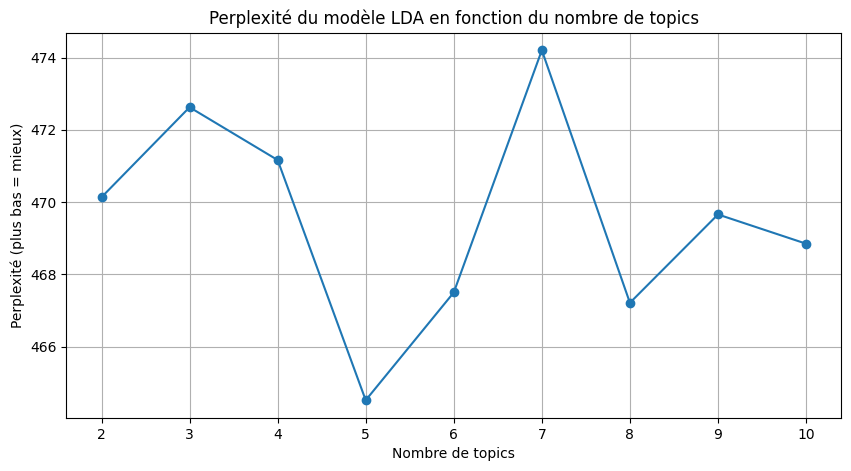

In [34]:
# Vectorisation du texte nettoyé (clean_text)
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(df['clean_text'])

# Liste des nombres de topics à tester
topic_numbers = [2, 3, 4, 5, 6, 7,  8, 9, 10]
perplexities = []

# Boucle sur chaque nombre de topics
for n in topic_numbers:
    lda = LatentDirichletAllocation(n_components=n, random_state=42)
    lda.fit(dtm)
    perplexity = lda.perplexity(dtm)
    perplexities.append(perplexity)
    print(f"n_topics = {n} → perplexity = {perplexity:.2f}")

# Tracer la courbe
plt.figure(figsize=(10, 5))
plt.plot(topic_numbers, perplexities, marker='o', linestyle='-')
plt.title("Perplexité du modèle LDA en fonction du nombre de topics")
plt.xlabel("Nombre de topics")
plt.ylabel("Perplexité (plus bas = mieux)")
plt.grid(True)
plt.show()

Le meilleur score de perplexité est atteint avec n=5, donc c’est le modèle statistiquement le plus performant sur notre corpus.

Cependant ceela ne garantit pas que les 4 topics sont bien interprétables. Il faut les examiner manuellement :

On va observer les mots les plus fréquentes 

In [35]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

### Matrice de probabilité 

In [36]:
# Recalcule les topics après avoir choisi n_components=5

topic_results = lda.transform(dtm)  #  nouvelle matrice de probabilités
topic_results.shape

for i, topic in enumerate(lda.components_):
    print(f"\nTOPIC {i}")
    print([vectorizer.get_feature_names_out()[j] for j in topic.argsort()[-20:]])


TOPIC 0
['forward', 'legislation', 'settlement', 'commonwealth', 'play', 'afghanistan', 'united', 'common', 'private', 'sector', 'support', 'public', 'great', 'policy', 'work', 'improve', 'community', 'visit', 'introduce', 'state']

TOPIC 1
['international', 'great', 'national', 'world', 'deal', 'people', 'condition', 'provide', 'act', 'relate', 'service', 'present', 'law', 'peace', 'proposal', 'country', 'trade', 'industry', 'lay', 'minister']

TOPIC 2
['service', 'community', 'security', 'support', 'provide', 'seek', 'development', 'bring', 'reform', 'economic', 'improve', 'maintain', 'forward', 'law', 'united', 'policy', 'promote', 'work', 'legislation', 'introduce']

TOPIC 3
['promote', 'seek', 'provision', 'states', 'power', 'effort', 'necessary', 'maintain', 'free', 'nations', 'lay', 'legislation', 'ally', 'world', 'force', 'commonwealth', 'minister', 'united', 'people', 'war']

TOPIC 4
['tackle', 'reduce', 'child', 'secure', 'include', 'ensure', 'support', 'provide', 'crime', '

### Topic dominant à chaque discours


In [37]:
df['Topic'] = topic_results.argmax(axis=1)
df

,Speech_Year,Date,PM,Parti,Text,n_tokens,n_chars,clean_text,Topic
0,1,1911-02-06,Herbert Henry Asquith,Libéral,"My Lords and Gentlemen, In opening the first P...",1041,6383,lord gentleman open parliament elect reign gri...,1
1,2,1912-02-14,Herbert Henry Asquith,Libéral,"My Lords and Gentlemen, My relations with fore...",849,5070,lord gentleman relation foreign power continue...,1
2,3,1913-03-10,Herbert Henry Asquith,Libéral,"My Lords and Gentlemen, To-day being the fifti...",1377,8289,lord gentleman day fiftieth anniversary marria...,1
3,4,1914-11-11,Herbert Henry Asquith,Libéral,"My Lords and Gentlemen, The energies and sympa...",656,3831,lord gentleman energy sympathy subject empire ...,1
4,5,1916-02-15,Herbert Henry Asquith,Libéral,"My Lords and Gentlemen, It has been My duty to...",281,1626,lord gentleman duty summon short recess renew ...,3
...,...,...,...,...,...,...,...,...,...
100,101,2007-11-06,Gordon Brown,Travailliste,"My Lords and Members of the House of Commons, ...",1326,8663,lord member house commons government forward p...,4
101,102,2008-12-03,Gordon Brown,Travailliste,"My Lords and Members of the House of Commons, ...",1290,8304,lord member house commons government override ...,4
102,103,2009-11-18,Gordon Brown,Travailliste,"My Lords and Members of the House of Commons, ...",1050,6985,lord member house commons government override ...,4
103,104,2010-05-25,David Cameron,Conservateur,"My Lords and Members of the House of Commons, ...",1187,7730,lord member house commons government legislati...,4


**Importance des mots dans le modèle, pour chaque topic**

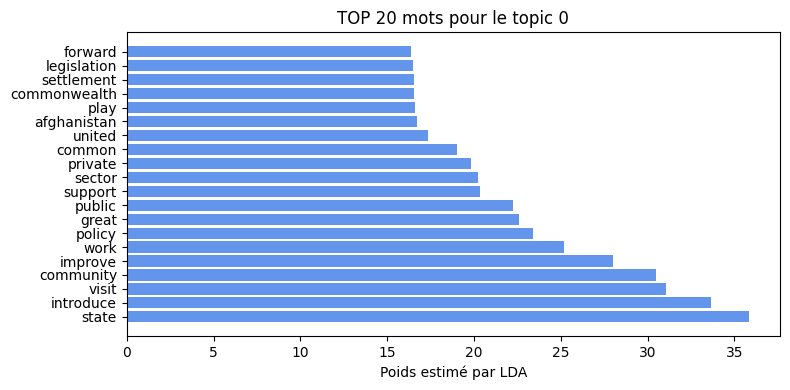

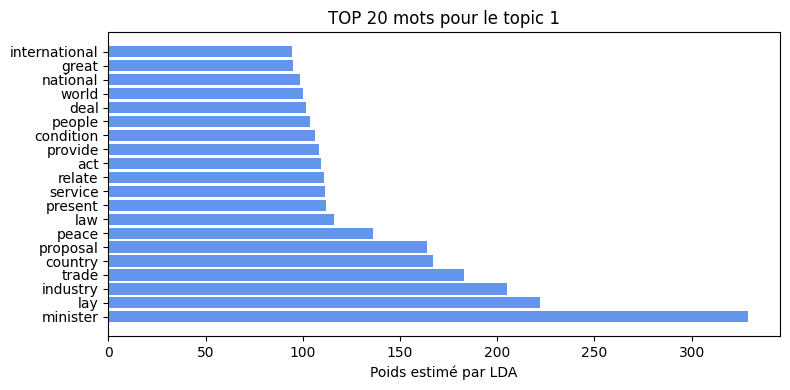

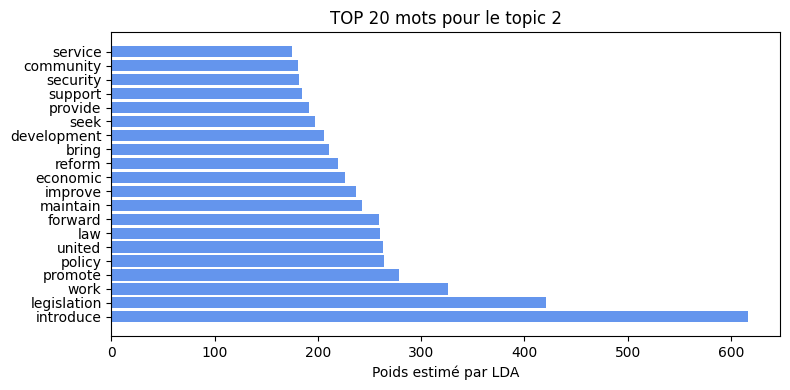

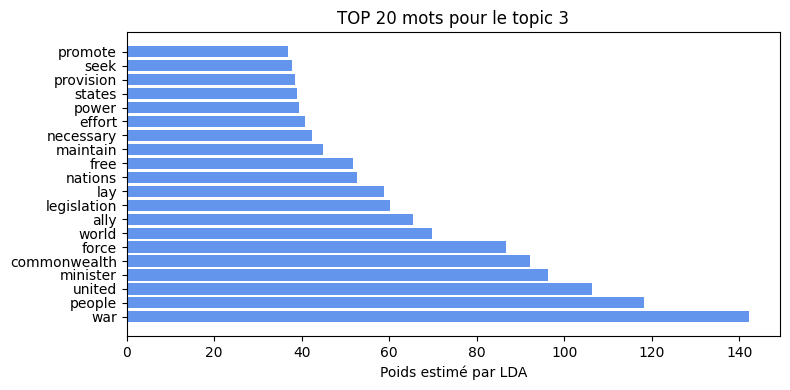

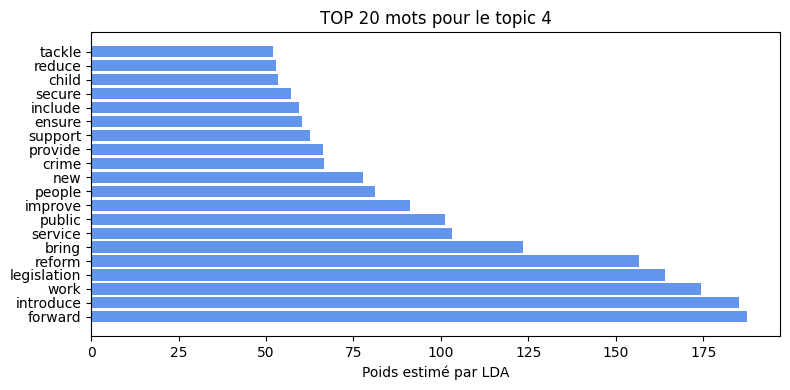

In [38]:

# Nombre de mots par topic
n_top_words = 20
feature_names = vectorizer.get_feature_names_out()

# Boucle sur chaque topic
for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-n_top_words:]
    top_words = [feature_names[i] for i in top_indices]
    top_values = topic[top_indices]
    
    plt.figure(figsize=(8, 4))
    plt.barh(top_words, top_values, color='cornflowerblue')
    plt.title(f"TOP {n_top_words} mots pour le topic {topic_idx}")
    plt.xlabel("Poids estimé par LDA")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


**Et aussi la sa fréquence réelle d’utilisation des ces mots dans le disocurs**

In [39]:
n_top_words = 20
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"\ TOPIC {topic_idx}")
    
    # Top mots par poids LDA
    top_indices = topic.argsort()[-n_top_words:]
    top_words = [feature_names[i] for i in top_indices]
    
    # Texte de tous les discours associés à ce topic
    text = " ".join(df[df['Topic'] == topic_idx]['clean_text'])
    word_counts = Counter(text.split())
    
    #  fréquence réelle des top mots
    for word in reversed(top_words):  # ordre descendant (plus haut en haut)
        print(f"{word:<15}  poids LDA: {topic[vectorizer.vocabulary_[word]]:.2f} | fréquence réelle: {word_counts[word]}")

\ TOPIC 0
state            poids LDA: 35.84 | fréquence réelle: 26
introduce        poids LDA: 33.67 | fréquence réelle: 30
visit            poids LDA: 31.04 | fréquence réelle: 20
community        poids LDA: 30.50 | fréquence réelle: 19
improve          poids LDA: 28.02 | fréquence réelle: 24
work             poids LDA: 25.17 | fréquence réelle: 19
policy           poids LDA: 23.38 | fréquence réelle: 20
great            poids LDA: 22.59 | fréquence réelle: 15
public           poids LDA: 22.25 | fréquence réelle: 17
support          poids LDA: 20.35 | fréquence réelle: 16
sector           poids LDA: 20.23 | fréquence réelle: 16
private          poids LDA: 19.83 | fréquence réelle: 12
common           poids LDA: 19.04 | fréquence réelle: 14
united           poids LDA: 17.33 | fréquence réelle: 15
afghanistan      poids LDA: 16.72 | fréquence réelle: 5
play             poids LDA: 16.58 | fréquence réelle: 11
commonwealth     poids LDA: 16.57 | fréquence réelle: 11
settlement       poids

Grace à ces résultats on peut savoir si ces mots sont anecdotiques ou structurels: 

On qualifie un mot de **structurel** dans un topic s’il est à la fois :

- fortement pondéré par LDA (poids élevé dans `lda.components_`)

- et fréquemment utilisé dans les discours assignés à ce topic (fréquence réelle élevée)

Un mot est considéré comme **anecdotique** s’il a un poids élevé dans LDAmais une fréquence réelle faible dans le corpus associé, ce qui signifie qu’il influence le modèle mais n’est pas vraiment représentatif des discours du topic.

**Mots structurels par topic**

- TOPIC 0 : state, introduce, community, policy, support, visit, sector, afghanistan, commonwealth

- TOPIC 1 : minister, trade, industry, law, peace, proposal, country, international, world

- TOPIC 2 : introduce, reform, development, policy, legislation, economic, support, service, community

- TOPIC 3 : war, force, people, ally, nation, free, minister, world, commonwealth

- TOPIC 4 : reform, public, service, child, crime, secure, ensure, support, include

**Topic ----- Nom interprété**

0 ----- TOPIC 0   Affaires internationales et gouvernance publique

1 ----- TOPIC 1  Diplomatie, commerce et législation internationale

2 ----- TOPIC 2  Réformes économiques et politiques publiques

3 ----- TOPIC 3  Guerre, défense et alliances internationales

4 ------ TOPIC 4 Protection sociale, justice et inclusion

**Graphique des topics et le label par année**

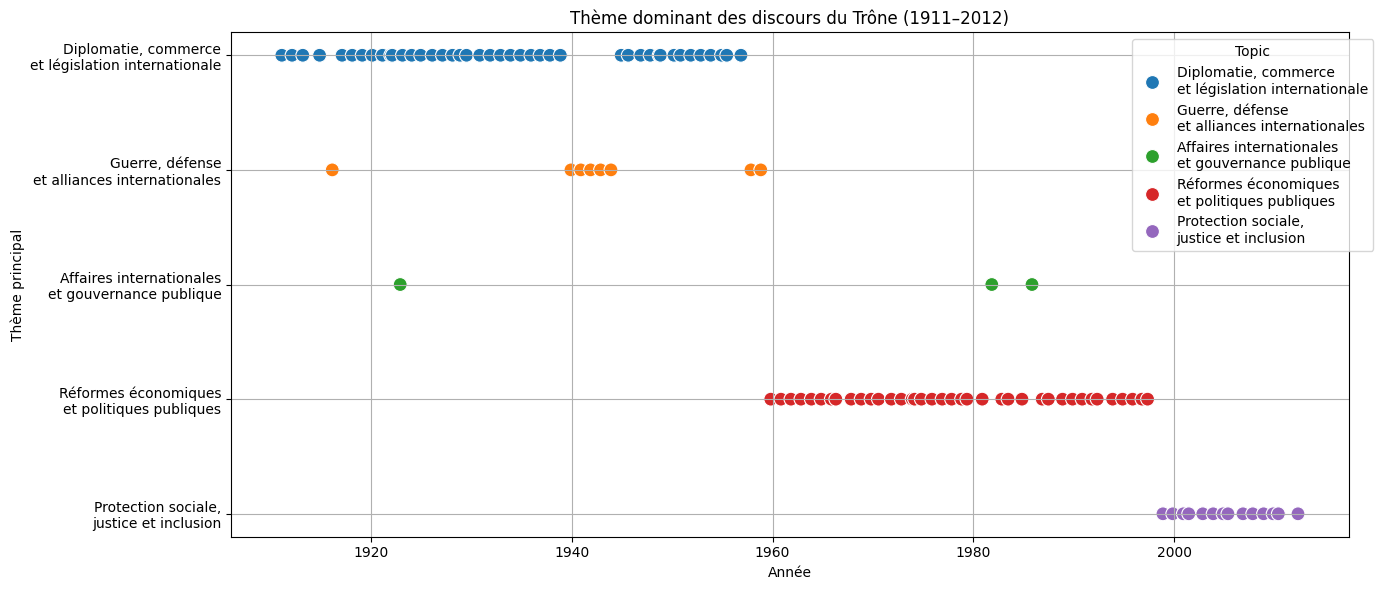

In [40]:
# on cree un label pour mieux comprendre 'Topic_Label' 
topic_labels = {
    0: "Affaires internationales\net gouvernance publique",
    1: "Diplomatie, commerce\net législation internationale",
    2: "Réformes économiques\net politiques publiques",
    3: "Guerre, défense\net alliances internationales",
    4: "Protection sociale,\njustice et inclusion"
}


df["Topic_Label"] = df["Topic"].map(topic_labels)

# graphique 

plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='Date',
    y='Topic_Label',
    hue='Topic_Label',
    palette='tab10',
    data=df,
    s=100
)
plt.title("Thème dominant des discours du Trône (1911–2012)")
plt.xlabel("Année")
plt.ylabel("Thème principal")
plt.legend(title='Topic', bbox_to_anchor=(0.8, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## V. Analyse de sentiment (optionnelle)

**VADER sur le texte original (Text)**

In [41]:
# score de sentiment global (compound) pour chaque discours
df['Sentiment'] = df['Text'].apply(lambda text: sid.polarity_scores(text)['compound'])

On parcourt chaque ligne de la colonne Text (c’est-à-dire chaque discours) et applique la fonction sid.polarity_scores(text) pour obtenir le score de sentiment global. Ensuite on récupère uniquement le score 'compound', une valeur entre -1 (négatif) et +1 (positif) et on stocke ce score dans une nouvelle colonne sentiment du data frame

In [42]:
# exemple à un seul discours 
text = df['Text'].iloc[0]
scores = sid.polarity_scores(text)
print(scores)

{'neg': 0.068, 'neu': 0.792, 'pos': 0.14, 'compound': 0.9971}


In [43]:
#Cette fonction transforme le score numérique (compound) en une étiquette lisible 
def interpret_sentiment(score):
    if score >= 0.05:   # seuil recommandé par la doc VADER (±0.05)
        return "positif"
    elif score <= -0.05:
        return "négatif"
    else:
        return "neutre"

df['Sentiment_Label'] = df['Sentiment'].apply(interpret_sentiment)  # nouvelle colonne textuelle, avec les labels "positif", "négatif" ou "neutre"



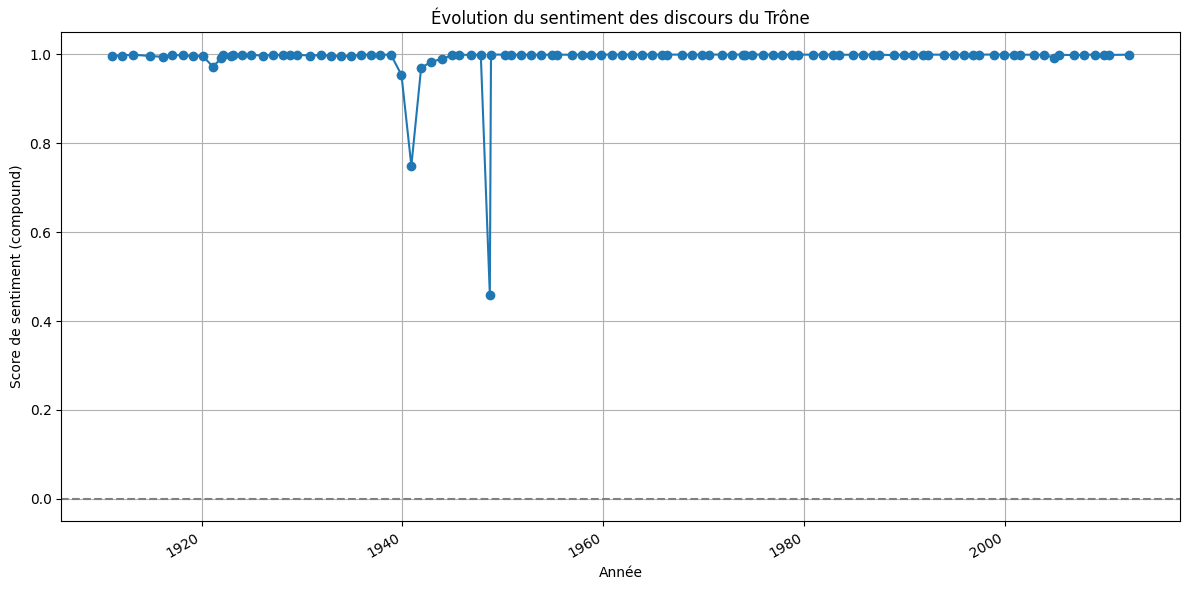

In [44]:
plt.figure(figsize=(12, 6))
df.groupby('Date')['Sentiment'].mean().plot(marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Évolution du sentiment des discours du Trône")
plt.xlabel("Année")
plt.ylabel("Score de sentiment (compound)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
df[['Date', 'Sentiment', 'Sentiment_Label', 'Topic_Label', 'Text']].sort_values('Sentiment').head(3)


,Date,Sentiment,Sentiment_Label,Topic_Label,Text
39,1948-09-14,0.4588,positif,"Diplomatie, commerce\net législation internati...",My Lords and Members of the House of Commons: ...
31,1940-11-21,0.7493,positif,"Guerre, défense\net alliances internationales","My Lords and Members of the House of Commons, ..."
30,1939-11-28,0.9537,positif,"Guerre, défense\net alliances internationales","My Lords and Members of the House of Commons, ..."


Extraire les phrases avec un score compound ≤ 0.3 dans le discours de 1948

In [46]:
# comprendre quelles phrases tirent le score du discours vers le bas

year_to_check = 1948

text = df[df['Date'].dt.year == year_to_check]['Text'].values[0]

doc = nlp(text)
seen = set()

for sent in doc.sents:
    s = sent.text.strip()
    if s in seen or len(s) < 20:
        continue
    seen.add(s)

    score = sid.polarity_scores(s)['compound']
    if score <= 0.3:
        print(f"\n{s}\n→ Score : {score}")



My Lords and Members of the House of Commons: I have summoned you to meet at this time in order that you may give further consideration to the Bill to amend the Parliament Act, 1911, on which there was disagreement between the two Houses last Session.
→ Score : -0.3612


La phrase évoque un conflit institutionnel entre les deux chambres du Parlement. Le roi convoque une session pour débloquer une situation de blocage législatif (un désaccord sur un projet de loi).

Bien que le ton soit formel et neutre dans le contexte politique réel, VADER, basé sur un lexique social, interprète cela comme conflictuel ou négatif

Cette phrase n’a pas un vocabulaire dramatique, mais exprime une tension politique

VADER attribue un score négatif à ce type de tension, même si le discours n'est pas émotionnellement chargé

In [47]:
words = text.lower().split()
vader_words = set(sid.lexicon.keys())

# Uniquement les mots uniques présents dans le lexique VADER
recognized = [(w, sid.lexicon[w]) for w in set(words) if w in vader_words]

# On trie par score (du plus négatif au plus positif)
recognized = sorted(recognized, key=lambda x: x[1])

#  10 mots les plus négatifs
for word, score in recognized[:10]:
    print(f"{word:<15} {score}")


disagreement    -1.5
pray            1.3
blessing        2.2


Extraire les phrases avec un score compound ≤ 0.3 dans le discours de 1940

In [48]:
# comprendre quelles phrases tirent le score du discours vers le bas

year_to_check = 1940
text = df[df['Date'].dt.year == year_to_check]['Text'].values[0]

doc = nlp(text)
seen = set()

for sent in doc.sents:
    s = sent.text.strip()
    if s in seen or len(s) < 20:
        continue
    seen.add(s)

    score = sid.polarity_scores(s)['compound']
    if score <= 0.3:
        print(f"\n{s}\n→ Score : {score}")



These are now enduring, where they live and labour, the perils as well as the hardships of war.
→ Score : -0.4215

The staunchness of the men of the Merchant and Fishing Fleets has added lustre to the ancient traditions of the sea.
→ Score : 0.0

The relations of My Government with that of the United States of America could not be more cordial, and I learn with the utmost satisfaction, of the ever-increasing volume of munitions of war which is arriving from that country.
→ Score : 0.2023

Members of the House of Commons, You will be asked to make further financial provision for the conduct of the war.
→ Score : -0.5994

You will be asked to make further financial provision for the conduct of the war.
→ Score : -0.5994

My Lords and Members of the House of Commons, Measures will be submitted to you for compensating those whose home or business property has, at any time since the outbreak of hostilities, been destroyed or damaged by enemy attack, and for extending insurance against the 


Le discours de 1940 contient de nombreuses phrases à charge émotionnelle négative (destruction, guerre, dépenses, épreuves), qui tirent le score vers le bas.

Cela confirme l'interprétation VADER : le discours est l’un des plus pessimistes de la série

In [49]:
words = text.lower().split()
vader_words = set(sid.lexicon.keys())

# Uniquement les mots uniques présents dans le lexique VADER
recognized = [(w, sid.lexicon[w]) for w in set(words) if w in vader_words]

# On trie par score (du plus négatif au plus positif)
recognized = sorted(recognized, key=lambda x: x[1])

#  10 mots les plus négatifs
for word, score in recognized[:10]:
    print(f"{word:<15} {score}")


war             -2.9
enemy           -2.5
destroyed       -2.2
prosecution     -2.2
damage          -2.2
damaged         -1.9
fight           -1.6
risk            -1.1
aggressor       -0.8
defence         0.4


# VI - Modélisation

In [50]:
# Filtre les discours du parti Travailliste et Conservateur
df_trav_cons = df[(df['Parti'] == "Travailliste") | (df['Parti'] == "Conservateur")]
df_trav_cons['Parti_num'] = df_trav_cons['Parti'].map({'Travailliste': 0, 'Conservateur': 1})

df_trav_cons.head()

,Speech_Year,Date,PM,Parti,Text,n_tokens,n_chars,clean_text,Topic,Topic_Label,Sentiment,Sentiment_Label,Parti_num
12,13,1922-11-23,Andrew Bonar Law,Conservateur,"My Lords and Members of the House of Commons, ...",621,3671,lord member house commons constitution irish f...,0,Affaires internationales\net gouvernance publique,0.9957,positif,1
13,14,1923-02-13,Andrew Bonar Law,Conservateur,"My Lords and Members of the House of Commons, ...",1113,6867,lord member house commons conference hold lond...,1,"Diplomatie, commerce\net législation internati...",0.9992,positif,1
14,15,1924-01-15,Stanley Baldwin,Conservateur,"My Lords and Members of the House of Commons, ...",2398,14858,lord member house commons relation foreign pow...,1,"Diplomatie, commerce\net législation internati...",0.9997,positif,1
15,16,1924-12-09,Stanley Baldwin,Conservateur,"My Lords and Members of the House of Commons, ...",2897,17511,campaign hostility british right interest egyp...,1,"Diplomatie, commerce\net législation internati...",0.9994,positif,1
16,17,1926-02-02,Stanley Baldwin,Conservateur,"My Lords and Members of the House of Commons, ...",1829,11014,parliament rise ambassador constantinople proc...,1,"Diplomatie, commerce\net législation internati...",0.9974,positif,1


In [51]:
# vectoriseur TF-IDF
vectorizer = TfidfVectorizer(use_idf=True, max_features=150)

# Appliquer le vectoriseur sur les textes nettoyés
X = vectorizer.fit_transform(df_trav_cons['clean_text'])  # 'clean_text' est une série de texte

# Convertir la matrice sparse en matrice dense (tableau numpy) pour un meilleur traitement avec train_test_split
X_dense = X.toarray()

# Définir y comme la colonne 'Parti_num' (labels)
y = df_trav_cons['Parti_num']

# Diviser les données en ensembles d'entraînement et de test (70% pour l'entraînement, 30% pour le test)
X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.3, random_state=42)

# Vérification de la forme des ensembles d'entraînement et de test
print(f"Ensemble d'entraînement X_train shape: {X_train.shape}")
print(f"Ensemble de test X_test shape: {X_test.shape}")
print(f"Labels d'entraînement y_train shape: {y_train.shape}")
print(f"Labels de test y_test shape: {y_test.shape}")

Ensemble d'entraînement X_train shape: (65, 150)
Ensemble de test X_test shape: (28, 150)
Labels d'entraînement y_train shape: (65,)
Labels de test y_test shape: (28,)


In [52]:
#print(X[:5].toarray())

In [53]:
y.value_counts(normalize=True)

Parti_num
1    0.602151
0    0.397849
Name: proportion, dtype: float64

In [54]:
y_train.value_counts(normalize=True)

Parti_num
1    0.615385
0    0.384615
Name: proportion, dtype: float64

In [55]:
y_test.value_counts(normalize=True)

Parti_num
1    0.571429
0    0.428571
Name: proportion, dtype: float64

**Modèles 1 : Règression logistique**

In [56]:

# Entraînement du modèle de régression logistique
lr_model = LogisticRegression(max_iter=1000, solver='lbfgs')
lr_model.fit(X_train, y_train)

# Prédire sur les données de test
y_pred = lr_model.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1])

In [57]:
pd.DataFrame(metrics.confusion_matrix(y_test,y_pred), index=['Travailliste', 'Conservateur'], columns=['Travailliste', 'Conservateur'])

,Travailliste,Conservateur
Travailliste,3,9
Conservateur,0,16


In [58]:

# Évaluer la performance du modèle avec les métriques d'accuracy, 
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.6785714285714286


**Modele 2:  Multinomial Naive Bayes**

In [59]:
nb_model = MultinomialNB()

nb_model.fit(X_train,y_train)

y_pred = nb_model.predict(X_test)

print(metrics.confusion_matrix(y_test,y_pred))

[[ 3  9]
 [ 0 16]]


**Modele 3:  SVM**

In [60]:
svc_model = SVC(gamma='auto')

svc_model.fit(X_train,y_train)

y_pred = svc_model.predict(X_test)

print(metrics.confusion_matrix(y_test,y_pred))

[[ 0 12]
 [ 0 16]]


**Modele 4:  Random Forest**

In [61]:
# Création du modèle de forêt aléatoire
model = RandomForestClassifier(n_estimators=50, random_state=42)

# Entraînement du modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer le modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7142857142857143
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        12
           1       0.67      1.00      0.80        16

    accuracy                           0.71        28
   macro avg       0.83      0.67      0.65        28
weighted avg       0.81      0.71      0.67        28



In [62]:
pd.DataFrame(metrics.confusion_matrix(y_test,y_pred), index=['Travailliste', 'Conservateur'], columns=['Travailliste', 'Conservateur'])

,Travailliste,Conservateur
Travailliste,4,8
Conservateur,0,16


In [63]:
# Évaluer la performance du modèle avec les métriques d'accuracy, 
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7142857142857143
